# QST-CGAN performance

Reconstructing the `cat` state from measurements of the Husimi Q function. The cat state is defined as:

$$|\psi_{\text{cat}} \rangle = \frac{1}{\mathcal N} ( |\alpha \rangle + |-\alpha \rangle \big ) $$

with $\alpha=2$ and normalization $\mathcal N$.

## Husimi Q function measurements

The Husimi Q function can be obtained by calculating the expectation value of measuring the following operator:

$$\mathcal O_i = \frac{1}{\pi}|\beta_i \rangle \langle \beta_i|$$

where $|\beta_i \rangle $ are coherent states written in the Fock basis.


In [1]:
import numpy as np

from qutip import coherent, coherent_dm, expect, Qobj, fidelity
from qutip.wigner import wigner, qfunc
from qutip.visualization import hinton


import tensorflow as tf

from tqdm.auto import tqdm

from qst_cgan.ops import convert_to_real_ops, batched_expect, tf_fidelity
from qst_cgan.gan import generator_loss, discriminator_loss, Generator, Discriminator


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from dataclasses import dataclass

%load_ext autoreload
tf.keras.backend.set_floatx('float64') # Set float64 as the default

/Users/shahnawaz/miniconda3/envs/qtensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


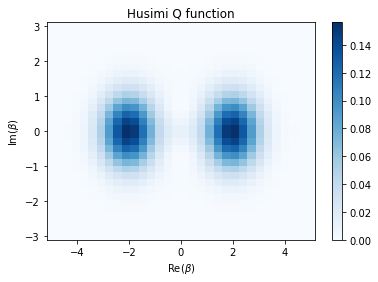

In [2]:
hilbert_size = 32
alpha = 2.

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace

grid = 32
xvec = np.linspace(-5, 5, grid)
yvec = np.linspace(-3, 3, grid)

q = qfunc(psi, xvec, yvec, g=2)

cmap = "Blues"
im = plt.pcolor(xvec, yvec, q, vmin=0, vmax=np.max(q), cmap=cmap, shading='auto')
plt.colorbar(im)
plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function")
plt.show()

# Construct the measurement operators and simulated data (without any noise)

In [3]:
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = [(1/np.pi)*coherent_dm(hilbert_size, beta) for beta in betas]

data = expect(m_ops, psi)

In [4]:
# Test if the expectation value of the measurement operators matches the Husimi Q function
np.testing.assert_array_almost_equal(data, q.ravel())

# Setup the inputs to the neural network - measurement ops and data

We need to convert the QuTiP qunatum objects to TensorFlow objects in order to feed them to the neural network.
We take 1024 operators (32 x 32 grid of complex $\beta$ values in the phase space). Each operator is a complex matrix
of size 32 x 32 since we choose a Hilbert space cutoff of 32. 

Once we convert the measurement operators to a TensorFlow complex tensor, we further separate the real and imaginary parts.
The measurement operators are therefore input as real matrix with the last dimension as (`2 x ` number of operators). We have 1024 operators and therefore the input to the neural networks is a $1 \times  32 \times 32  \times 2048$ dimensional tensor containing the real and imaginary parts of the all the complex-valued measurement operators.

In [5]:
ops_numpy = [op.full() for op in m_ops] # convert the QuTiP Qobj to numpy arrays
ops_tf = tf.convert_to_tensor([ops_numpy]) # convert the numpy arrays to complex TensorFlow tensors

print(ops_tf.shape, ops_tf.dtype)

(1, 1024, 32, 32) <dtype: 'complex128'>


2022-04-11 14:36:26.625333: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
A = convert_to_real_ops(ops_tf) # convert the complex-valued numpy matrices to real-valued TensorFlow tensors
print(A.shape, A.dtype)

(1, 32, 32, 2048) <dtype: 'float64'>


# Batched expectation values using TensorFlow


In [7]:
rho = psi*psi.dag() # Density matrix in QuTiP
rho_numpy = rho.full().reshape((1, hilbert_size, hilbert_size)) # Conversion to NumPy array and reshaping into (1, N, N) to allow batching
rho_tf = tf.complex(rho_numpy.real, rho_numpy.imag)

x = batched_expect(ops_tf, rho_tf)

Let us visualize the data obtained by computing expectation values using TensorFlow versions of QuTiP functions

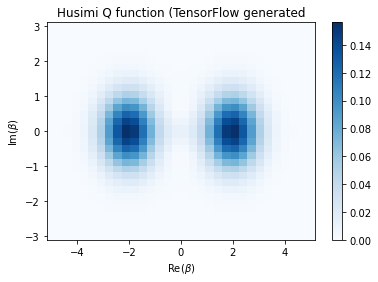

In [8]:
im = plt.pcolor(xvec, yvec, x.numpy().reshape((grid, grid)),vmin=0, vmax=np.max(q), cmap=cmap, shading='auto')
plt.colorbar(im)
plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function (TensorFlow generated")
plt.show()

# Training the Conditional Generative Adversarial Network (CGAN)

We construct a `Generator` and a `Discriminator` using TensorFlow and train them for state reconstruction in an adversarial fashion. The inputs to the CGAN are the data (`x`) and the measurement operators converted as real matrices `A`. 

In [9]:
num_measurements = x.shape[-1]
print(num_measurements)

generator = Generator(hilbert_size, num_measurements, noise=0.) # Specify the number of measurement settings and Gaussian noise
discriminator = Discriminator(hilbert_size, num_measurements)

1024


## Generator

In [10]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          524288      inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16, 16, 2)    0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

## Discriminator

In [11]:
print(discriminator.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 1024)]       0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 1024)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      concatenate[0][0]          

# Training

We train the networks using TensorFlow optimizers and record the loss function as well as intermediate density matrices during training. In order to get the intermediate density matrices, we construct a `density matrix` model called `model_dm` model that outputs the density matrix using the generator.

In [12]:
density_layer_idx = None

for i, layer in enumerate(generator.layers):
    if "density_matrix" in layer._name:
        density_layer_idx = i
        break

print(density_layer_idx)
model_dm = tf.keras.Model(inputs=generator.input, outputs=generator.layers[density_layer_idx].output)

@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []

17


In [13]:
initial_learning_rate = 0.0002

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                             decay_steps=10000,
                                                             decay_rate=.96,
                                                             staircase=False)

lam = 100.

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

max_iterations = 10000


In [14]:
def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, x, lam=lam
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)


pbar = tqdm(range(max_iterations))
for i in pbar:
    train_step(A, x)
    density_matrix = model_dm([A, x])
    f = tf_fidelity(density_matrix, rho_tf)[-1]
    fidelities.append(f)
    pbar.set_description("Fidelity {} | Gen loss {} | L1 loss {} | Disc loss {}".format(f, loss.generator[-1], loss.l1[-1], loss.discriminator[-1]))

Fidelity 0.9900913406573801 | Gen loss 0.6931478977203369 | L1 loss 0.00011080290130411176 | Disc loss 1.3862943649291992:  38%|███▊      | 3800/10000 [13:25<21:53,  4.72it/s]


KeyboardInterrupt: 

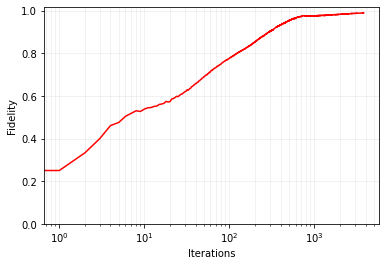

In [15]:
iterations = np.arange(len(fidelities))
plt.plot(iterations, fidelities, color="red", label="QST-CGAN")
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.ylim(0, 1.02)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.2)
plt.xscale('log')
plt.show()

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_44790/391115164.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, data.reshape((grid, grid)), cmap="Blues")
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_44790/391115164.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(xvec, yvec, data_predicted.reshape((grid, grid)), cmap="Blues")


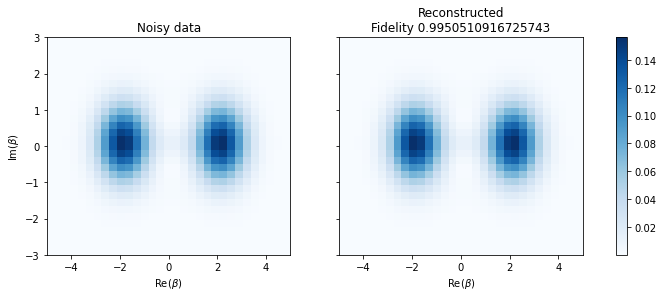

In [16]:
density_matrix = model_dm([A, x])
rho_predicted = Qobj(density_matrix.numpy().reshape((hilbert_size, hilbert_size)))
data_predicted = qfunc(rho_predicted, xvec, yvec, g= 2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

im = ax[0].pcolor(xvec, yvec, data.reshape((grid, grid)), cmap="Blues")
ax[1].pcolor(xvec, yvec, data_predicted.reshape((grid, grid)), cmap="Blues")

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")
ax[0].set_title("Noisy data")
ax[1].set_title("Reconstructed\nFidelity {}".format(fidelity(rho, rho_predicted)))
plt.colorbar(im, ax=[axis for axis in ax])
plt.show()

In [17]:
xvec2 = np.linspace(-3, 3, 100)
yvec2 = np.linspace(-3, 3, 100)

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_44790/99663585.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec2, yvec2, wigner(rho, xvec2, yvec2, g= 2), cmap="RdBu_r")
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_44790/99663585.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(xvec2, yvec2, wigner(rho_predicted, xvec2, yvec2, g= 2), cmap="RdBu_r")


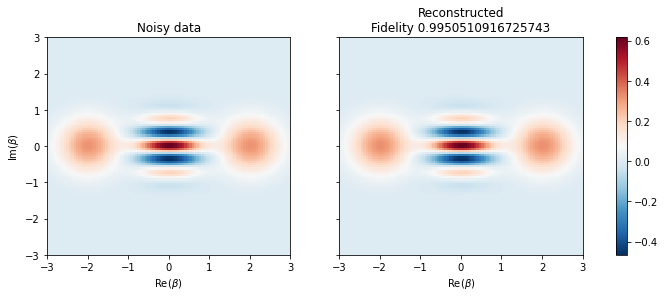

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

im = ax[0].pcolor(xvec2, yvec2, wigner(rho, xvec2, yvec2, g= 2), cmap="RdBu_r")
ax[1].pcolor(xvec2, yvec2, wigner(rho_predicted, xvec2, yvec2, g= 2), cmap="RdBu_r")

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")
ax[0].set_title("Noisy data")
ax[1].set_title("Reconstructed\nFidelity {}".format(fidelity(rho, rho_predicted)))
plt.colorbar(im, ax=[axis for axis in ax])
plt.show()

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

hinton(rho, ax=ax[0])
hinton(rho_predicted, ax=ax[1])

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")
ax[0].set_title("True")
ax[1].set_title("Reconstructed\nFidelity {}".format(fidelity(rho, rho_predicted)))
plt.show()

/Users/shahnawaz/miniconda3/envs/qtensorflow/lib/python3.9/site-packages/qutip/visualization.py:320: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/shahnawaz/miniconda3/envs/qtensorflow/lib/python3.9/site-packages/qutip/visualization.py:328: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))
/Users/shahnawaz/miniconda3/envs/qtensorflow/lib/python3.9/site-packages/qutip/visualization.py:320: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/shahnawaz/miniconda3/envs/qtensorflow/lib/python3.9/site-packages/qutip/visualization.py:328: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))
